# Protein design VAE: $1^{st}$ step
### Xinran Lian, Andrew Ferguson, Rama Ranganathan
---
https://stackoverflow.com/questions/49941426/attributeerror-collections-ordereddict-object-has-no-attribute-eval

All codes should be run under Python3.  
Prior to running this material, please 
* Make sure you already installed the newest version of the following python packages: **numpy, pandas, numba, scipy, matplotlib, torch, sklearn, Bio**. [Conda environment](https://www.anaconda.com) will be helpful.   

* If your input sequences are not aligned, you are recommended to align it with pySCA/scaProcessMSA.py. See SCA documention [here](https://ranganathanlab.gitlab.io/pySCA/)  
  We have a shell script *runsca_SH3* for MSA of SH3, it is necessary if you want to evaluate the VAE model with SCA (statistical coupling analysis). Please install all SCA dependencys before excuting this script from the command line as:  
  
  ./runsca_SH3.sh


* Execute the scripts from the command line as follows:   

  cd source  
  ./preprocessing.py ../Inputs/sh3_59.fasta -n SH3  
  ./train_model.py -n SH3  
  
  
* Additionally, please run the following script to generate new sequences:  

  ./Generate_many_seqs.py -g 50000 -n SH3
---
Explain roles of each script:  
* *preprocessing.py*:  
  Convert the fasta file to ont-hot Potts representation, and compute plmDCA parameters for MSA.  
   
   
* *train_model.py*:  
  Train the VAE model  
  
  
* *Generate_many_seqs_SH3.py*: 
  Generate new sequences and compute their  
    * $log(tr(H^TP))$
    * Min Hamming distance from MSA
    * plmDCA energy
    (Please run ./Generate_many_seqs_SH3.py --help  
    for details of the arguments.)

In [1]:
from __future__ import division 
import sys
import numpy as np
import pickle
from numba import jit
import time
from ipywidgets import interact, interactive, fixed, interact_manual

from scipy.spatial import distance
from scipy.stats import scoreatpercentile 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.utils.data
from sklearn.decomposition import IncrementalPCA

sys.path.append('./pySCA/pysca')
import scaTools as sca
sys.path.append('./source')
import toolkit
sys.path.append('../')

device = torch.device("cpu")

---
## Import the dataset and VAE model

### Import dataset
We are going to use the following annotations in this notebook:
* **$N$** number of samples
* **$q$** number of one-hot features
* **$n$** number of amino acid residues in a sequence

In [2]:
# The -n argument of ./preprocessing.py
proteinname = 'SH3'

In [247]:
path = 'Outputs/'

# Import the Potts sequence. 
parameters = pickle.load(open(path + proteinname + ".db", 'rb'))

q_n = parameters['q_n'] # Number of possible residues on each position
v_traj_onehot = parameters['onehot'] # The one-hot encoded sequences

N=np.size(v_traj_onehot,axis=0) #number of samples 
q=np.size(v_traj_onehot,axis=1) #number of one-hot features
n=np.size(q_n) # number of amino acid residues in a sequences

print("Number of samples = ", N)
print("Number of features = ", q)
print('Number of amino acids = ', n)

Number of samples =  5299
Number of features =  1178
Number of amino acids =  59


### Import VAE

In [4]:
class VAE(nn.Module):
    def __init__(self, q, d):
        super(VAE, self).__init__()
        self.hsize=int(1.5*q) # size of hidden layer
        
        self.en1 = nn.Linear(q, self.hsize)
        self.en2 = nn.Linear(self.hsize, self.hsize) #
        self.en3 = nn.Linear(self.hsize, self.hsize)
        self.en_mu = nn.Linear(self.hsize, d)
        self.en_std = nn.Linear(self.hsize, d) # Is it logvar?
        
        self.de1 = nn.Linear(d, self.hsize)
        self.de2 = nn.Linear(self.hsize, self.hsize) #
        self.de22 = nn.Linear(self.hsize, self.hsize)
        self.de3 = nn.Linear(self.hsize, q)     
 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()        
        self.softmax = nn.Softmax(dim=1)
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm1d(self.hsize) # batchnorm layer
        self.bn2 = nn.BatchNorm1d(self.hsize)
        self.bn3 = nn.BatchNorm1d(self.hsize)
        self.bnfinal = nn.BatchNorm1d(q)  

        #replace tanh with relu
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        x = self.tanh(self.en1(x)) # first encode
        x = self.dropout1(x) 
        x = self.tanh(self.en2(x))
        x = self.bn1(x)
        x = self.tanh(self.en3(x)) # second encode
        return self.en_mu(x), self.en_std(x) # third (final) encode, return mean and variance
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        z = self.tanh(self.de1(z))
        z = self.bn2(z)
        z = self.tanh(self.de2(z))
        z = self.dropout2(z)
        z = self.tanh(self.de22(z))
        
        # residue-based softmax
        # - activations for each residue in each position ARE constrained 0-1 and ARE normalized (i.e., sum_q p_q = 1)
        z = self.bn3(z)
        z = self.de3(z)
        z = self.bnfinal(z)
        z_normed = torch.FloatTensor() # empty tensor?
        z_normed = z_normed.to(device) # store this tensor in GPU/CPU
        for j in range(n):
            start = np.sum(q_n[:j])
            end = np.sum(q_n[:j+1])
            z_normed_j = self.softmax(z[:,start:end])
            z_normed = torch.cat((z_normed,z_normed_j),1)
        return z_normed
    
    def reparam(self, mu, logvar): 
        """Reparameterisation trick to sample z values. 
        This is stochastic during training, and returns the mode during evaluation.
        Reparameterisation solves the problem of random sampling is not continuous, which is necessary for gradient descent
        """
        if self.training:
            std = logvar.mul(0.5).exp_() 
            eps = std.data.new(std.size()).normal_() # normal distribution
            return eps.mul(std).add_(mu)
        else:
            return mu      
    
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, q)) # get mean and variance
        z = self.reparam(mu, logvar) # sampling latent variable z from mu and logvar
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar): 
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, q))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, q).data.shape[0] * q 
        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        mu, logvar = self.encode(x.view(-1, q))
        return self.reparam(mu, logvar)

In [5]:
# Load the trained VAE
d=3
model = VAE(q,d)
model_init = VAE(q,d)
model.load_state_dict(torch.load('source/VAE.pyt',map_location='cpu'))
model.eval()

VAE(
  (en1): Linear(in_features=1178, out_features=1767, bias=True)
  (en2): Linear(in_features=1767, out_features=1767, bias=True)
  (en3): Linear(in_features=1767, out_features=1767, bias=True)
  (en_mu): Linear(in_features=1767, out_features=3, bias=True)
  (en_std): Linear(in_features=1767, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=1767, bias=True)
  (de2): Linear(in_features=1767, out_features=1767, bias=True)
  (de22): Linear(in_features=1767, out_features=1767, bias=True)
  (de3): Linear(in_features=1767, out_features=1178, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(1767, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1767, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1767, eps=1e-05, momentum=0.1, affine=True, tr

---
## Model Validation

### Internal validation: how well the model reconstruct natural sequences
**1. Reconstruction accuracy**

In [6]:
# Reconstruct ont-hot representation for input sequences by the trained VAE by encoding and decoding.
def reconstruct(model, sequence_list, q_n):
    model.eval()
    real_ref = torch.FloatTensor(sequence_list) 
    pred_ref, mu_ref, logvar_ref = model(real_ref)
    pred_ref = pred_ref.cpu().detach().numpy().reshape([-1,sum(q_n)])
    
    sequence_list = sequence_list.reshape([-1,sum(q_n)])
    length = np.size(sequence_list,axis=0)
    reconstruct_nothot = np.zeros([length,len(q_n)])
    
    for i in range(length):
        for j in range(len(q_n)):
            start = np.sum(q_n[:j])
            end = np.sum(q_n[:j+1])
            reconstruct_nothot[i,j] = np.argmax(pred_ref[i,start:end])
    return (reconstruct_nothot)

In [7]:
real_nohot_list = toolkit.convert_nohot(v_traj_onehot, q_n)
z_test = model.get_z(torch.FloatTensor(v_traj_onehot)).cpu().detach().numpy() 
test_recons = reconstruct(model, v_traj_onehot, q_n)
Hamming_list = [int(n*distance.hamming(test_recons[i],real_nohot_list[i])) for i in range(len(v_traj_onehot))]

mean_acc = np.mean((test_recons==real_nohot_list).astype(int),axis=0) # List of mean reconstruction accuracy

print("Mean accuracy = %2f" %np.mean(mean_acc))

Mean accuracy = 0.627451


Explanation of the variables:  
  
* **real_nohot_list** int representation of MSA  
* **z_test** The latent variables  
* **test recons** int representation of reconstructed sequences  
* **Hamming_list** Hamming distances from the original MSA and reconstructed sequences.   
* **mean_acc** List of mean reconstruction accuracy at each position ($accuracy^i$), namely  
  
$accuracy^i=\frac{1}{N}\sum_{i=1}^{N} \delta(a_i- \hat{a}_i)$ 
  
Then we plot the histogram of reconstruction Hamming distances for MSA and bar plot of $accuracy^i$:

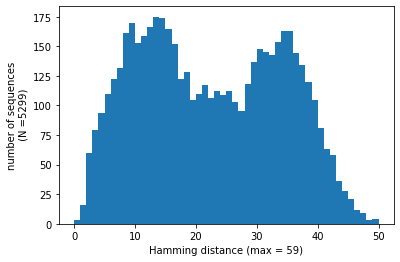

In [8]:
plt.rcParams.update({'font.size': 10})
plt.hist(Hamming_list, max(Hamming_list))
plt.xlabel('Hamming distance (max = %d)' %n)
plt.ylabel('number of sequences\n (N ='+str(len(v_traj_onehot))+')')
plt.show()

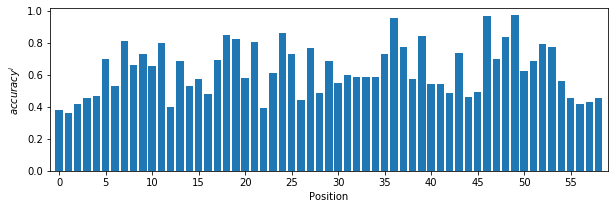

In [9]:
plt.figure(figsize = (10,3))
plt.bar(np.arange(n),mean_acc)
plt.xticks(np.arange(0,n,5))
plt.xlim([-1,n])
plt.xlabel('Position')
plt.ylabel('$accuracy^i$')
plt.show()

To compare reconstruction accuracy with first order statistics, at beginning we load the SCA database of MSA:

In [11]:
try:
    db = pickle.load(open('Inputs/sh3_59.db','rb'))
    Dseq = db['sequence']  #the results of scaProcessMSA
    Dsca = db['sca']       #the results of scaCore
    Dsect = db['sector']   #the results of scaSectorID

    Di_list = Dsca['Di']
except FileNotFoundError:
    print('Please firstly proceed SCA pipeline on your fasta file. (See begining of this notebook)')
    raise

In [12]:
acc_tmp = (test_recons==real_nohot_list).astype(int)
mean_acc = np.mean(acc_tmp,axis=0) # List of mean reconstruction accuracy

We compare the $accuracy^i$ with Kullback-Leibler relative entropy $D_i$ at each position $i$:   
  
  $D_i^a = f_i^aln\frac{f_i^a}{p^a}+(1-f^a_i)ln\frac{1-f_i^a}{a-p^a}$  
  
  $D_i = \sum_{a=0}^{20}f^a_iln(\frac{f_i^a}{p^a})$ 
    
  where  
*  $a_i$ is the amino acid at position $i$ in the real sequence.   
*  $p^a$ is the background distribution of amino acid $a$  
*  $f_i^a$ is frequency of amino acid $a$ at position $i$
  
The following scatter diagram is going to show the relationship between $D_i$ and $accuracy^i$

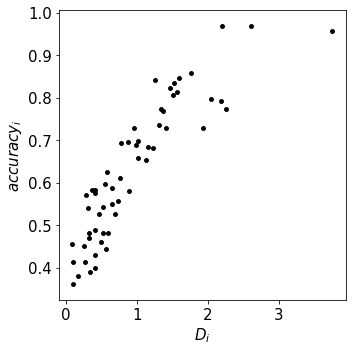

In [13]:
set_size = 15

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
ax1.set_ylabel('$accuracy_i$', fontsize=set_size)
ax1.set_xlabel('$D_i$', fontsize=set_size)
ax1.scatter(Di_list, mean_acc[:-1], c='k',s = set_size)
ax1.tick_params(axis='y',labelsize=set_size)
ax1.tick_params(axis='x',labelsize=set_size)
fig.tight_layout()
plt.show()

**2. VAE log probability**
  
Using the model trained by MSA, the probability of each input sequence can be estimated as 
  
$logP(x|z) \propto log[tr(H^TP)]$  

where  
* $H$ is an $21×L$ matrix representing the one-hot encoding of a sequence  
* $P$ is the probability weight matrix generated by feeding the network a sequence. 

For the first step, we compute **log_p_list**, which is the list of $log[tr(H^TP)]$ for each sequence. 

*Ref. https://arxiv.org/abs/1712.03346*

In [12]:
st_time = time.time()

pred_ref,_,_ = model(torch.FloatTensor(v_traj_onehot))
p_weight = pred_ref.cpu().detach().numpy()
log_p_list = np.array(toolkit.make_logP(v_traj_onehot, p_weight,q_n))
    
end_time = time.time()
print("Elapsed time %.2f (s)" % (end_time - st_time))

Elapsed time 2.25 (s)


Then we show the $H$ and $P$ matrix of a sequence of interest.  
  
**Hint**: Run this block, text the index of your interested sequence in the text box on the right side of the scroll bar, then press Enter.

In [35]:
def show_matrices(test_seq):
    print("Reconstruction Hamming distance: ", Hamming_list[test_seq])
    cmap = 'hot'
    plt.rcParams.update({'font.size': 14})

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
    gened = axes[0].imshow(toolkit.make_matrix(v_traj_onehot[test_seq], n, q_n),cmap = cmap)
    axes[0].set_title('one-hot encoding matirx $H$')

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(gened, cax=cax)

    msa = axes[1].imshow(toolkit.make_matrix(p_weight[test_seq], n, q_n),cmap = cmap)
    axes[1].set_title('Reconstruction probability weight matrix $P$')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(gened, cax=cax)

    plt.tight_layout()
    
interact(show_matrices, test_seq = N-1)
plt.show()

interactive(children=(IntSlider(value=5298, description='test_seq', max=15894, min=-5298), Output()), _dom_cla…

Finally, we plot the adjusted log probability, which is $log[tr(H^TP)]$ normalized by setting completely accurate reconstruction as zero, equally 

$log[tr(H^{T}P)] - log(L)$  v.s. reconstruction Hamming distance.  
  
The log Probability is negatively correlated with reconstruction Hamming distance. In other words, higher reconstruction accuracy means higher probability of a sequence to occur.

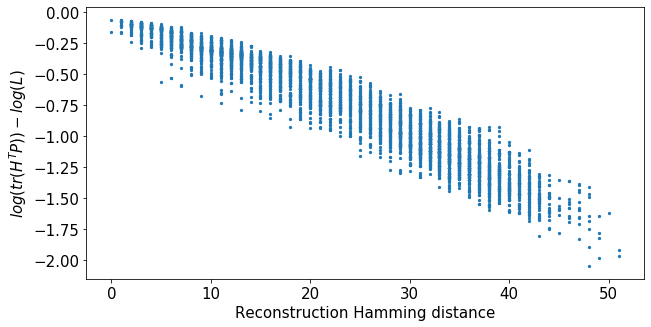

In [16]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(Hamming_list,log_p_list, s = 5)
plt.xlabel('Reconstruction Hamming distance')
plt.ylabel('$log(tr(H^{T}P)) - log(L)$')
#plt.ylim([-np.log(n),0])
plt.show()

maxlogP = -0.061


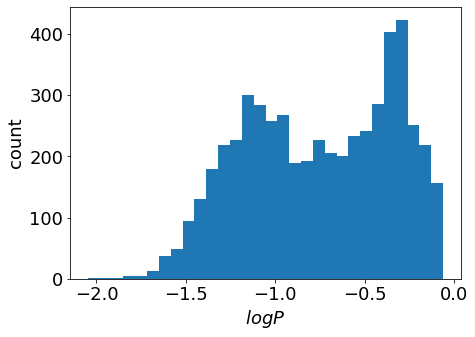

In [17]:
plt.figure(figsize = [7,5])
print('maxlogP = %.3f' %max(log_p_list))
plt.rcParams.update({'font.size': 18})
plt.hist(log_p_list, 30)
plt.ylabel('count')
plt.xlabel('$logP$')
plt.show()

In [145]:
np.save('logp_msa.npy',log_p_list)

**3. Mapping MSA in the 3D VAE latent space**
 

In [290]:
RE = np.load('../RE.npz')['RE_mapping']
records_MSA = parameters['seq']
for num, i in enumerate(records_MSA):
    if 'DADDA' in i:
        sho1 = i
        sho1_id = num
        break

In [292]:
for i in range(N):
    if 'GRWW' in parameters['seq'][i]:
        print(parameters['seq'][i],RE[i])

NFTYTVKALYSYQADDDAYESFDQGEILKVSDIEGRWWKAKRNGQTGIIPSNYVELIDT -0.6033042234694281
NFTYTVKALYSYKADDDAYESFEQGDILKVSDIEGRWWKARKNGQTGIIPSNYVKLMD- -0.2995513694699736
CVGLRAEALYDYRRNQPEELSFKKGDTFDVLDNSGRWWEVRKSDGTTGTALANCLQILS -3.074854776980791
EYPYKAKAIYSYDANPANEISFTKGEELEVSDVSGRWWQARRNGETGIAPSNYLILL-- -0.1938301059683094
EYPYKAKAIYSYDANPANEISFAKGEELEVSDVSGRWWQARRNGETGIAPSNYLILL-- -0.23323019904420828
SFPYTAKTLYSYQADAAYEISFDQGEILKVSDIEGRWWKAKRNGETGIIPSNYVQLIDN -0.370162570666442
EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKSGDTGIAPSNYLILL-- -0.5655414545547648
EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKSGETGIAPSNYLILL-- -0.25323314231330585
EYPYRAKAIYSYEANPANEISFTKHEILEVSDVSGRWWQARKNGDTGIAPSNYLILL-- -0.008343869071349097
EYPYRAKAIYSYEANPANEISFQKHEILEVSDVSGRWWQARKNGDTGIAPSNYLILL-- -0.44400645625550217
EYPYRAKAIYSYEANPANEISFSKHEILEISDVSGRWWQARKNGETGIAPSNYLILL-- -0.3070928113753566
EYPYKAKAIYKYEANPANEIGFEKGEELEVSDVSGRWWQARKNGETGIAPSNYLILL-- -0.35909714451628205
EYPYRAKAIYTYEANPANEISFSKHEILEVSDVSGR

In [286]:
latent_dim = 0
a1=v_traj_onehot @ v_traj_onehot[sho1_id]/59
a2=np.sqrt(np.sum((z_test - z_test[sho1_id,:])**2, axis = 1))

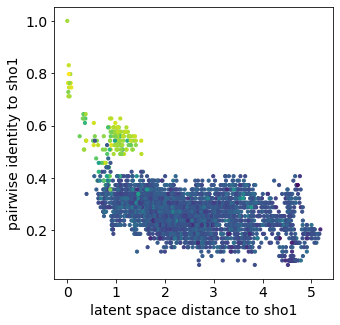

In [287]:
plt.figure(figsize = [5,5])
plt.scatter(a2,a1, s = 10, c = RE)
plt.xlabel('latent space distance to sho1')
plt.ylabel('pairwise identity to sho1')
plt.show()

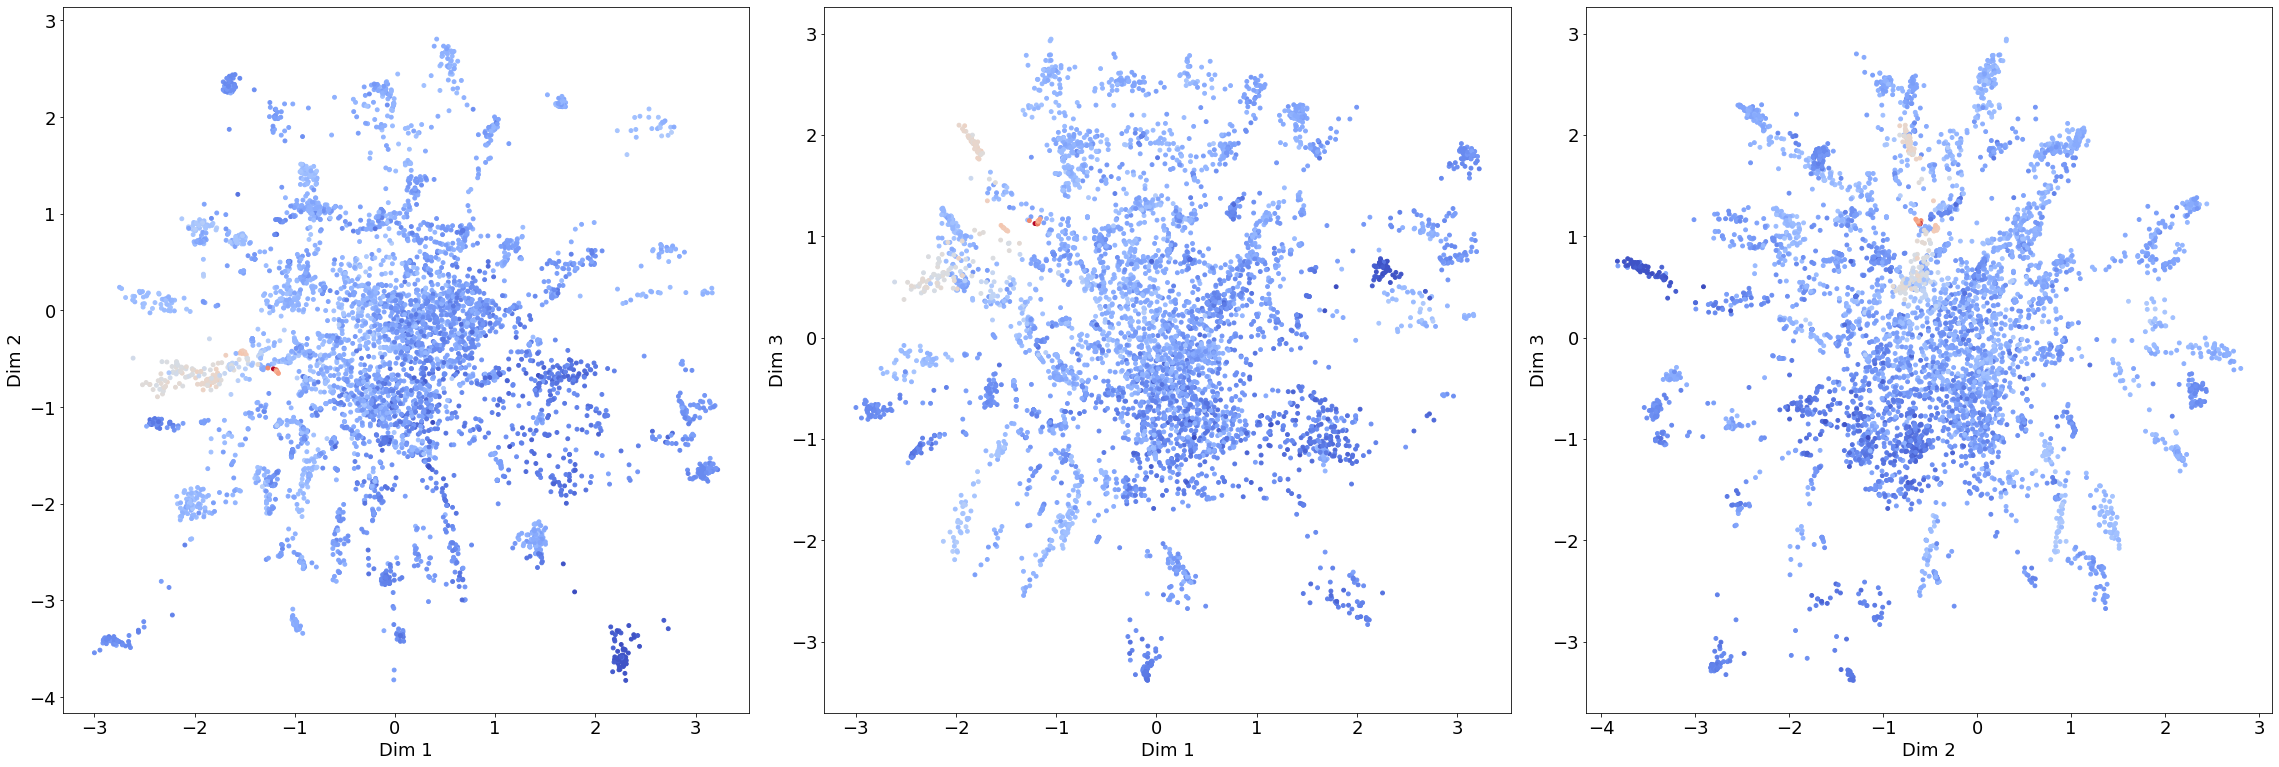

In [12]:
cmap = plt.cm.tab20
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1,3,figsize=[32,11])
c = v_traj_onehot @ v_traj_onehot[sho1_id]
axs[0].scatter(z_test[:,0], z_test[:,1],s=15, c=c,cmap=plt.cm.coolwarm)
axs[1].scatter(z_test[:,0], z_test[:,2],s=15, c=c,cmap=plt.cm.coolwarm)
axs[2].scatter(z_test[:,1], z_test[:,2],s=15, c=c,cmap=plt.cm.coolwarm)
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')
axs[2].set_xlabel('Dim 2')
axs[2].set_ylabel('Dim 3')
plt.tight_layout()
plt.show()

/Users/xinran/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xinran/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


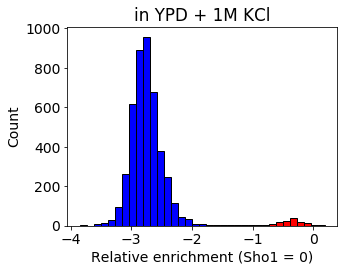

In [299]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = [5,4])
N_hist1, bins, patches = ax.hist(RE,35,color = 'r', edgecolor='k',linewidth=1)
ax.set_xlabel('Relative enrichment (Sho1 = 0)')
ax.set_ylabel('Count')
ax.set_title('in YPD + 1M KCl')
for i in range(0,18):    
    patches[i].set_facecolor('b')
plt.tight_layout()
plt.savefig('../../VAE_design_paper/samplingFig/re.pdf')
plt.show()

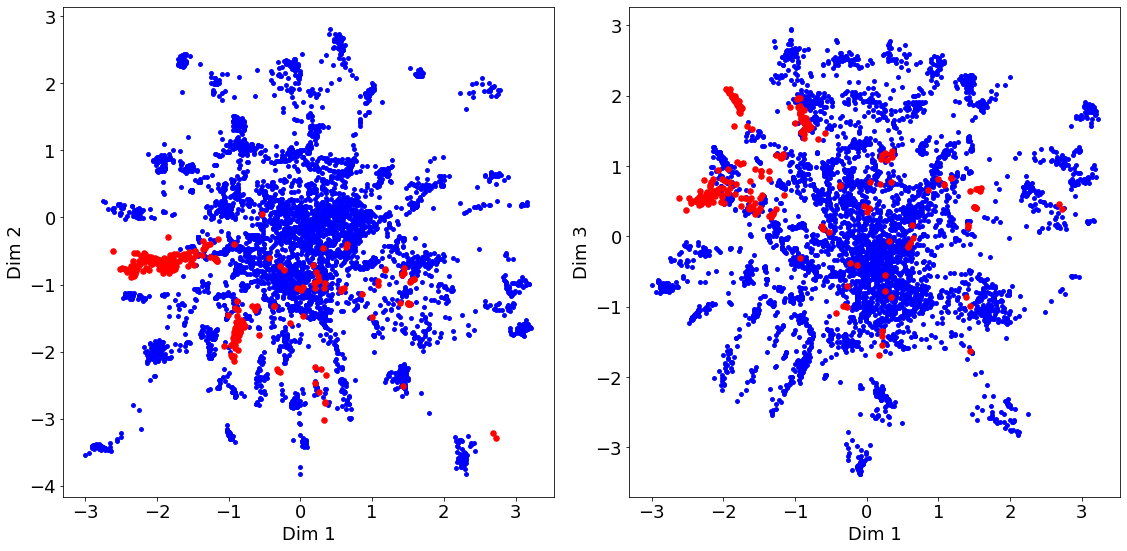

In [153]:
tst = [] # orthologs
for num, i in enumerate(parameters['seq']):
    #if 'GRWW' in i or 'GKWW' in i:
    if i[-12:-10] in ['II','IA','IV']:
    #if i[-8:-6] == 'NY':
        tst.append(num)
paralogs = [i for i in range(N) if i not in tst]

fig, axs = plt.subplots(1,2,figsize=[16,8])
plt.rcParams.update({'font.size': 18})
axs[0].scatter(z_test[paralogs,0], z_test[paralogs,1],s=15, c='b')
axs[1].scatter(z_test[paralogs,0], z_test[paralogs,2],s=15, c='b')
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')

#tst = [i+1 for i in tst]
axs[0].scatter(z_test[tst,0], z_test[tst,1],s=30, c = 'r')
axs[1].scatter(z_test[tst,0], z_test[tst,2],s=30, c = 'r')

plt.tight_layout()
plt.show()

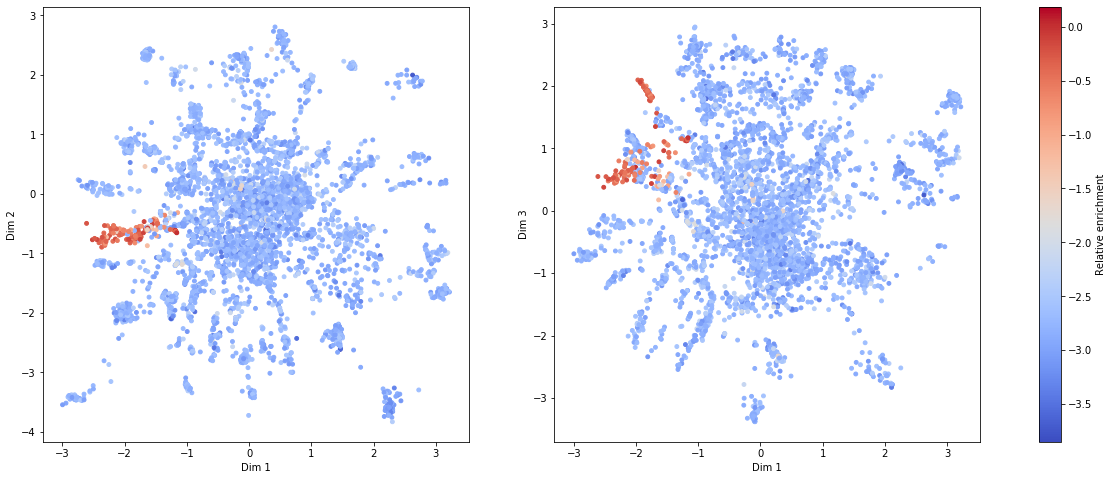

In [27]:
fig, axs = plt.subplots(1,2,figsize=[21,8])
c = RE
cmap = plt.cm.coolwarm
s1 = axs[0].scatter(z_test[:,0], z_test[:,1],s=15, c = c, cmap=cmap)#, vmax = -0.5730, vmin = -2.63)
s2 = axs[1].scatter(z_test[:,0], z_test[:,2],s=15, c = c, cmap=cmap)#, vmax = -0.5730, vmin = -2.63)
#s3 = axs[2].scatter(z_test[:,1], z_test[:,2],s=15, c = c, cmap=cmap)

axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')
#axs[2].set_xlabel('Dim 2')
#axs[2].set_ylabel('Dim 3')

cbar = fig.colorbar(s1, ax = axs[:], location = 'right')
cbar.ax.set_ylabel('Relative enrichment')

plt.show()

In [28]:
RE_plot = []
good_seqs = []
thresh =  -1.7185 #4sigma
for num, i in enumerate(RE):
    if i<thresh:
        pass
    elif i>=thresh:
        RE_plot.append(i)
        good_seqs.append(num)
    else:
        continue

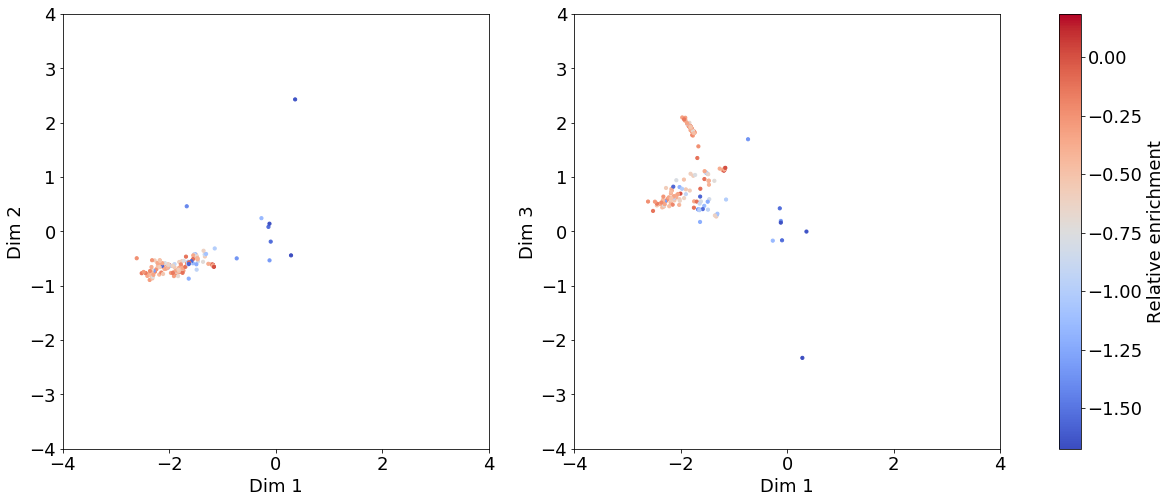

In [19]:
fig, axs = plt.subplots(1,2,figsize=[21,8])
c = RE_plot
cmap = plt.cm.coolwarm
s1 = axs[0].scatter(z_test[good_seqs,0], z_test[good_seqs,1],s=10, c = c, cmap=cmap)
s2 = axs[1].scatter(z_test[good_seqs,0], z_test[good_seqs,2],s=10, c = c, cmap=cmap)
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')

for i in range(2):
    axs[i].set_xlim([-4,4])
    axs[i].set_ylim([-4,4])

cbar = fig.colorbar(s1, ax = axs[:], location = 'right')
cbar.ax.set_ylabel('Relative enrichment')

plt.show()

In [267]:
RE_color = []
for i in RE:
    if i>thresh:
        RE_color.append('r')
    elif i<=thresh:
        RE_color.append('b')
    else:
        RE_color.append('darkgrey')

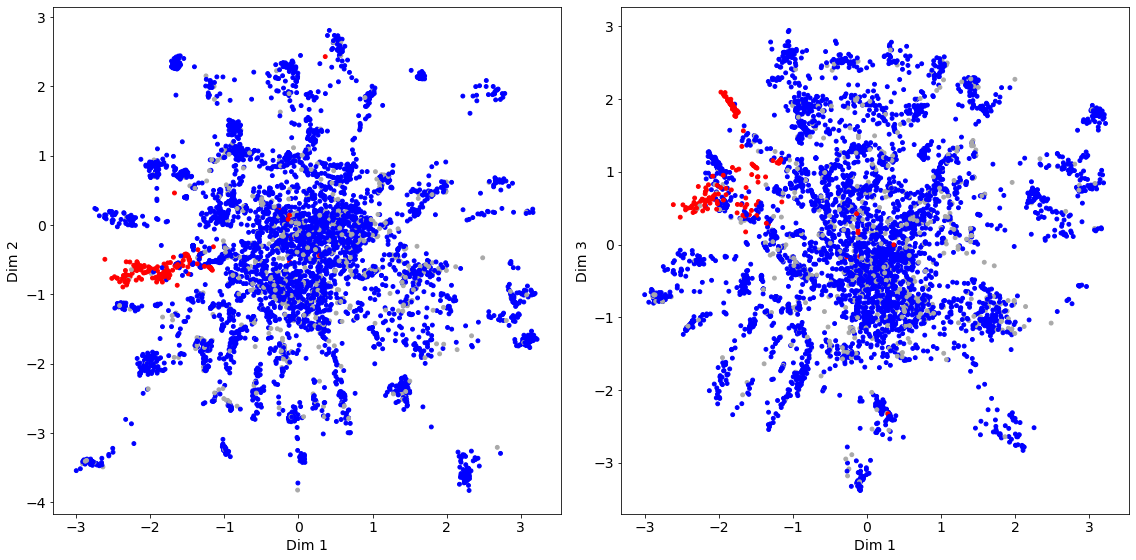

In [269]:
fig, axs = plt.subplots(1,2,figsize=[16,8])
c = RE_color
axs[0].scatter(z_test[:,0], z_test[:,1],s=15, c = c)
axs[1].scatter(z_test[:,0], z_test[:,2],s=15, c = c)
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')
plt.savefig('../../VAE_design_paper/samplingFig/latent.pdf')
plt.tight_layout()
plt.show()

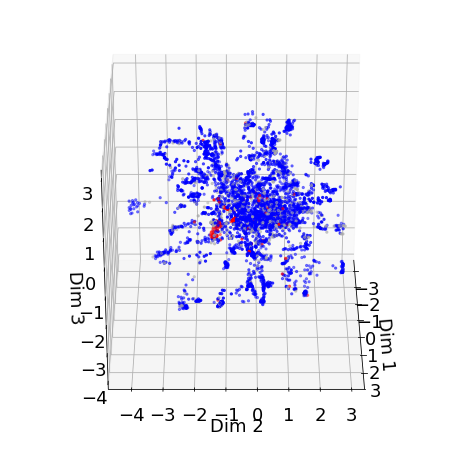

In [34]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_test[:,0], z_test[:,1],z_test[:,2], s = 5, c = RE_color)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

# Make animation
def rotate(angle):
    ax.view_init(azim=angle)
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 10), interval=200)
rot_animation.save('../figures/rotation.mp4', dpi = 80)

### Local sampling

In [191]:
n_sp = 150
np.random.seed(98850) #700
z_gen=np.random.normal(np.mean(z_test[good_seqs,:], axis = 0), 
                       np.var(z_test[good_seqs,:], axis = 0), (n_sp, d))
data = torch.FloatTensor(z_gen).to(device)
data = model.decode(data) # Use the decoding layer to generate new sequences.
v_gen = data.cpu().detach().numpy()

sample_list = []
for i in range(n_sp): # number of sampling points
        for k in range(10): # number of trials at each point
            v_samp_nothot = toolkit.sample_seq(k, q, n, q_n, i, v_gen)
            sample_list.append(v_samp_nothot)
localsmp = toolkit.convert_alphabet(np.array(sample_list), parameters['index'], q_n)

# Filtering to maximize diversity.
chooseset = np.unique(localsmp) # Firstly remove duplicated sequences
choose = [chooseset[0]]
# Make min Hamming distance > 3 for every pair of sequences.
for i in chooseset:
    aa2inti = [toolkit.aa2int(j,toolkit.plm_dict.dict_aa2int) for j in choose]
    if toolkit.minHamming(toolkit.aa2int(i, toolkit.plm_dict.dict_aa2int), aa2inti)>3:
        choose.append(i)
        
# manually adjust a few sequences to reduct affect of misplacement in alignments.
for num, i in enumerate(choose):
    if i[33]=='-' and i[35] in ['R','K','N']:
        choose[num] = i[:33]+i[34]+'G'+i[35:]
    if 'EG-W' in i:
        choose[num] = i.replace('EG-W', 'EGRW')
    if 'SG-W' in i:
        choose[num] = i.replace('SG-W', 'SGRW')
    if 'KG-W' in i:
        choose[num] = i.replace('KG-W', 'KGRW')
    if i[0] == '-':
        choose[num] = i.replace(i[0], 'N')
        
r1=0
k1=0
choose_ortho = []
for i in choose:
    if 'RWW' in i and i[11] in 'FYWRS' and i[18] in 'EGA':
        choose_ortho.append(i)
        r1+=1
    if 'KWW' in i and i[11] in 'FYWRS' and i[18] in 'EGA':
        choose_ortho.append(i)
        k1+=1
print('RWW ', r1)
print('KWW ', k1)
print('%d orthologs out of %d chosen sequences.' %(r1+k1, len(choose)))

RWW  237
KWW  178
415 orthologs out of 896 chosen sequences.


In [31]:
int_local = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in choose]
int_msa = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in parameters['seq']]
min_Ham_local = []
for i in int_local:
    min_Ham_local.append(toolkit.minHamming(i, int_msa))

In [236]:
tst = []
for i in range(len(choose)):
    if choose[i][11] not in 'YFRW':
        tst.append(i)
tst = np.array(tst)

In [244]:
#choose_ortho
#[choose[i] for i in tst]
#[choose[i] for i in range(len(choose)) if i not in tst]
v_traj_newortho, _ = toolkit.convert_potts([choose[i] for i in tst], parameters['index'])
recons_newortho,_,_ = model(torch.FloatTensor(v_traj_newortho))
recons_newortho = recons_newortho.cpu().detach().numpy() 
z_2 = model.get_z(torch.FloatTensor(v_traj_newortho)).cpu().detach().numpy() 

[[-1.244996   -0.58445704  1.1122208 ]
 [-1.244996   -0.58445704  1.1122208 ]]


In [35]:
v_traj_local, _ = toolkit.convert_potts(choose, parameters['index'])
recons_local,_,_ = model(torch.FloatTensor(v_traj_local))
recons_local = recons_local.cpu().detach().numpy() 
log_p_local = np.array(toolkit.make_logP(v_traj_local, recons_local,q_n))

### Compute logP of designed sequences

In [138]:
finals, head = toolkit.get_seq('Outputs/Final_New_Proteins.fasta',get_header=1)
p={'VAE_':[],'VAElocal':[],'bmDCA9':[]}
for i in ['VAE_','VAElocal','bmDCA9']:
    for j in range(len(finals)):
        if i in head[j]:
            tmp = str(finals[j])
            tmp = tmp[:16]+tmp[18:44]+tmp[45:]
            p[i].append(tmp)

In [139]:
lp={'VAE_':[],'VAElocal':[],'bmDCA9':[]}
for i in ['VAE_','VAElocal','bmDCA9']:
    v, _ = toolkit.convert_potts(p[i], parameters['index'])
    r,_,_ = model(torch.FloatTensor(v))
    r = r.cpu().detach().numpy() 
    lp[i]=np.array(toolkit.make_logP(v, r,q_n))

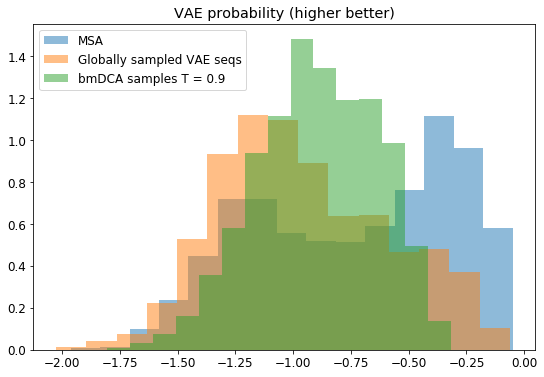

In [142]:
nbin = 15
plt.figure(figsize = [9,6])
plt.title('VAE probability (higher better)')
plt.hist(log_p_list,nbin, alpha = .5, density=1, label = 'MSA')
plt.hist(lp['VAE_'], nbin, alpha = .5, density=1, label = 'Globally sampled VAE seqs')
plt.hist(lp['bmDCA9'], nbin, alpha = .5, density=1, label = 'bmDCA samples T = 0.9')
plt.legend()
plt.show()

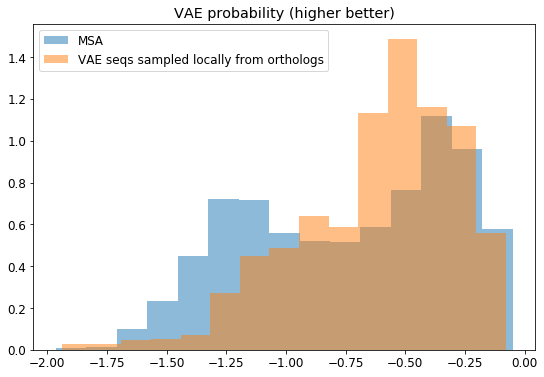

In [144]:
nbin = 15
plt.figure(figsize = [9,6])
plt.title('VAE probability (higher better)')
plt.hist(log_p_list,nbin, alpha = .5, density=1, label = 'MSA')
plt.hist(lp['VAElocal'], nbin, alpha = .5, density=1, label = 'VAE seqs sampled locally from orthologs')
plt.legend()
plt.show()

In [29]:
possible_z = []
possible_ortho = []
z_list = np.array([[i]*10 for i in z_gen]).reshape(-1,3)
for num, i in enumerate(localsmp):
    # Possible orthologs
    if 'GRWW' in i or 'GKWW' in i:
        possible_z.append(z_list[num])
        possible_ortho.append(num)

possible_z = np.unique(possible_z, axis = 0)

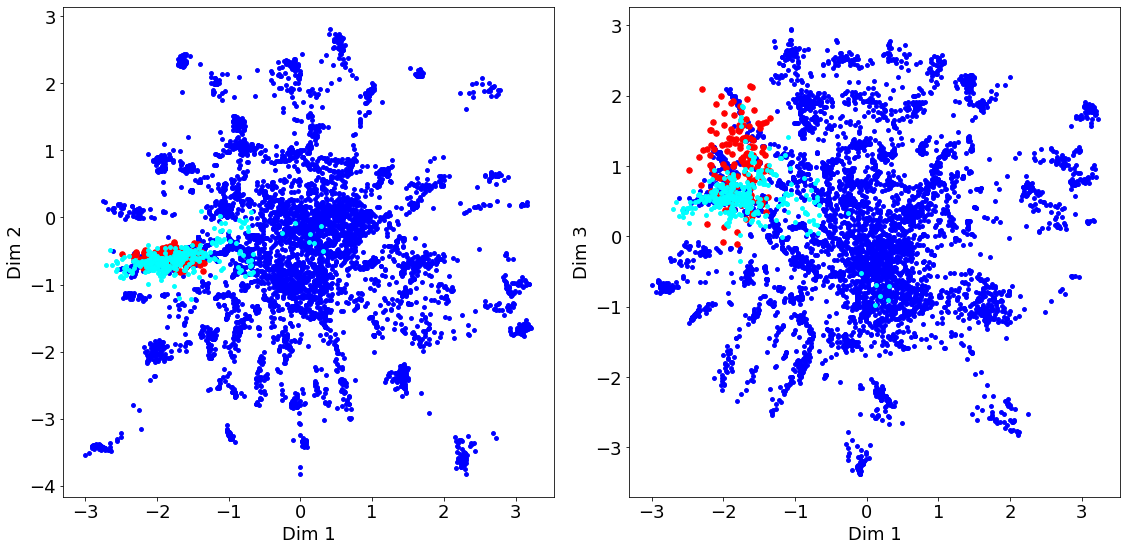

In [30]:
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1,2,figsize=[16,8])

axs[0].scatter(z_test[:,0], z_test[:,1],s=15, c = 'b')
axs[1].scatter(z_test[:,0], z_test[:,2],s=15, c = 'b')
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')

axs[0].scatter(possible_z[:,0], possible_z[:,1],s=30, c = 'r')
axs[1].scatter(possible_z[:,0], possible_z[:,2],s=30, c = 'r')

axs[0].scatter(z_2[:,0], z_2[:,1],s=15, c = 'cyan')
axs[1].scatter(z_2[:,0], z_2[:,2],s=15, c = 'cyan')

plt.tight_layout()
plt.show()

In [31]:
with open('Outputs/new_local.fasta', 'w') as f: # 1e4 seqs for bmDCA for comparasion
    for i,item in enumerate(choose):
        f.write(">%s\n" %str(i))
        f.write("%s\n" %item)

---
### GPR test
GPR test for natural sequences. Only a small fraction (RE > -1.5) are taken.

In [134]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split

In [139]:
X = [z_test[i, :] for i in range(N) if RE[i]>-1.5]
y = [i for i in RE if i>-1.5]
kernel = DotProduct() + WhiteKernel()

In [158]:
training_classification = []
for i in range(N):
    if RE_color[i]!= 'darkgrey':
        training_classification.append(np.array([z_test[i, :], RE_color[i] != 'b']))

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=33)
gpr = GaussianProcessRegressor(kernel = kernel, random_state=2).fit(X_train, y_train)
gpr.score(X_train, y_train), gpr.score(X_test, y_test)

(0.5451000872272829, 0.39116905379774874)

---
### External validation: Analyze VAE generated sequences


As is described in the beginning, before executing the following blocks, the python script *Generate_many_seqs* should be run to generate millions sequences:  
  
./Generate_many_seqs.py -g 20000 -r 1000 -n SH3  

The evaluation is composed of 3 sections:
* Predict mutation effect of Sho1  
* Visualize the three optimizing objectives and compute Pareto shells to pick up sequences for experiments
* Evaluate $10^4$ generated sequences by SCA (requires additional job)

**1. Predict mutation effect of Sho1**  
Seems not good. Probably not good if including paralogs.  
But may still contain useful information?

In [32]:
# Change one position to alanine and test the average mutation effect through all sequences
ind = parameters['index']
diff_list = np.zeros([N,n])
mut_alllist = []
for num1, pos in enumerate(sho1):
    for aa in ind[num1]:
        mut_alllist.append(sho1[:num1] + aa + sho1[num1 + 1:])
mut_potts, _ = toolkit.convert_potts(mut_alllist, ind)

In [36]:
pred_mut,_,_ = model(torch.FloatTensor(mut_potts))
mut_p = pred_mut.cpu().detach().numpy()
p_diff = np.array(toolkit.make_logP(mut_potts, mut_p,q_n)) - log_p_list[sho1_id]

In [37]:
dms = -np.ones([n, 21])
dict_dms = {'-ACDEFGHIKLMNPQRSTVWY'[i]:i for i in range(21)}
plus = 0
for num, pos in enumerate(sho1):
    k = 0
    for aa in ind[num]:
        dms[num, dict_dms[aa]] = p_diff[plus + k]
        k += 1
    plus += len(ind[num])

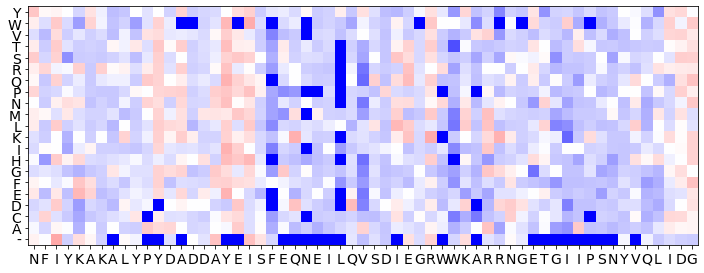

In [42]:
plt.figure(figsize = [12,6])
plt.imshow(dms.T, cmap = plt.cm.bwr, vmin = -.3, vmax = .3)
plt.xticks(range(n), list('NFIYKAKALYPYDADDAYEISFEQNEILQVSDIEGRWWKARRNGETGIIPSNYVQLIDG'))
plt.yticks(range(21), list('-ACDEFGHIKLMNPQRSTVWY'))
plt.ylim([-.5,20.5])
plt.show()

---
**3. Evaluate $10^4$ generated sequences by SCA (optional)**  
All technical details about SCA can be found in [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004817). Here we only demonstrate the codes to retrieve the distribution of correlations and sector decomposition, to show that our model have learned statistical patterns in the MSA.  

If you want to analyze your VAE generated sequences by SCA, run the following command line to generate 10000 sequences without filtering. Notice that we need all of the sequences to maintain the statistic pattern, and 10000 sequences are enough for stable pattern.  
  
  ./Generate_many_seqs.py -n SH3 -c 1e4 -a
  
<font color='red'> 
* **Warning:**  
    The SCA database file is very large (>700MB).  
    Because SCA is expensive, do not enable SCA (-a) while generating large number (millions) of sequences. **
</font> 
  
After computing, we load the SCA databases for both MSA and VAE generated sequences:

In [104]:
db = pickle.load(open(path + proteinname+'1e4_sca.db','rb'))
Dseq = db['sequence']  #the results of scaProcessMSA
Dsca = db['sca']       #the results of scaCore
Dsect = db['sector']   #the results of scaSectorID

db_ref = pickle.load(open('Inputs/sh3_59.db','rb'))
Dseq_ref = db_ref['sequence']  
Dsca_ref = db_ref['sca']       
Dsect_ref = db_ref['sector']

In [105]:
print("After processing, the alignment size of VAE generated sequences is %i sequences and %i positions" % \
      (Dseq['Nseq'], Dseq['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq['effseqs']))
print()
print("After processing, the alignment size of MSA is %i sequences and %i positions" % \
      (Dseq_ref['Nseq'], Dseq_ref['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq_ref['effseqs']))

After processing, the alignment size of VAE generated sequences is 8463 sequences and 59 positions
With sequence weights, there are 6911 effective sequences

After processing, the alignment size of MSA is 4551 sequences and 58 positions
With sequence weights, there are 2639 effective sequences


In [106]:
def scaMat(alg, seqw=1, lbda=0, freq0=np.ones(20) / 21,):
    N_seq, N_pos = alg.shape
    N_aa = 20
    if isinstance(seqw, int) and seqw == 1:
        seqw = np.ones((1, N_seq))
    freq1, freq2, freq0 = sca.freq(alg, Naa=N_aa, seqw=seqw, lbda=lbda, freq0=freq0)
    return freq1, freq2 - np.outer(freq1, freq1)

In [107]:
gen_1e4 = np.load('Outputs/SH31e4gen_data.npz')
int_new = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in gen_1e4['seq'][:N]]
new_f1, new_f2 = scaMat(np.array(int_new), seqw=1, lbda=0, freq0=np.ones(20) / 21,)
int_msa = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in parameters['seq']]
msa_f1, msa_f2 = scaMat(np.array(int_msa), seqw=1, lbda=0, freq0=np.ones(20) / 21,)

We firstly show the $1^{st}$ ($D_i$) and $2^{nd}$ (${\widetilde{C}_{ij}}$) order statistics of MSA between MSA and  sequences generated by VAE. 

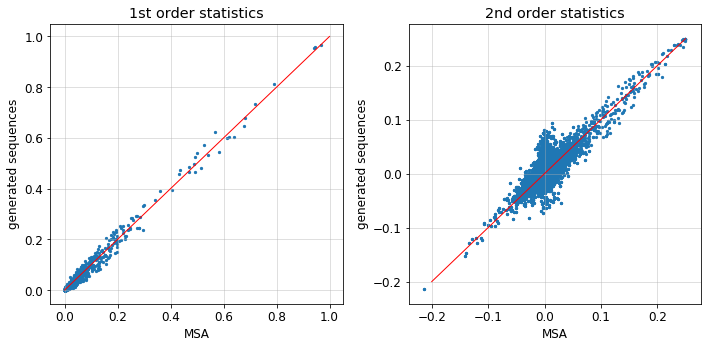

In [108]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.rcParams.update({'font.size': 12})

for i in range(2):
    axs[i].set_ylabel('generated sequences')
    axs[i].set_xlabel('MSA')
    axs[i].grid(alpha = .5)

axs[0].scatter(msa_f1,new_f1,s=5)
axs[0].plot([0,1.],[0,1.],'r',lw=1)
axs[0].set_title('1st order statistics')

axs[1].scatter(msa_f2,new_f2,s=5)
axs[1].plot([-.2,.25],[-.2,.25],'-r',lw=1)
axs[1].set_title('2nd order statistics')

plt.tight_layout()
plt.savefig('../figures/corr.png',dpi=300)
plt.show()

In [109]:
import scipy.cluster.hierarchy as sch

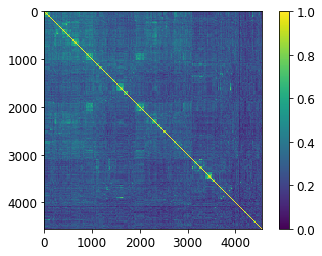

In [110]:
Z = sch.linkage(Dsca_ref['simMat'], method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z, no_plot = True)
ind = R['leaves']
plt.imshow(Dsca_ref['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();

* Sector decomposition

In [111]:
def Sector_decompos(dsect,dseq, max_n_sec = 3):
    Vpica = dsect['Vpica']
    for k in range(dsect['kpos']):
        iqr = scoreatpercentile(Vpica[:,k],75) - scoreatpercentile(Vpica[:,k],25)
    sec_groups = [[i] for i in range(dsect['kpos'])]
    sectors = list()

    c = [0.4,0,0.7,0.15,0.9,0.5] 
    for n,k in enumerate(sec_groups):
        s = sca.Unit()
        all_items = list()
        all_Vp = list()
        for i in k: 
            all_items = all_items+dsect['ics'][i].items
            all_Vp = all_Vp+list(dsect['ics'][i].vect)
        svals = np.argsort(all_Vp)    
        s.items = [all_items[i] for i in svals]
        s.col = c[n]
        sectors.append(s)
        if n > max_n_sec-2:
            break

    ic_list = []
    for i,k in enumerate(sectors):
        sort_ipos = sorted(k.items)
        ats_ipos = ([dseq['ats'][s] for s in sort_ipos])
        ic_pymol = (', '.join(ats_ipos))
        #ic_list.append([int(i) for i in ats_ipos])
        ic_list.append(sort_ipos)
        print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
        print(ic_pymol + "\n")
        if i>max_n_sec-2:
            break
    return ic_list

def color_match(sg, sr): # Return a sg to match color with sr. sg: generated; sr: reference
    sg_new = []
    for i in sr:
        sg_tmp = np.argmax([len(set(i) & set(sg_i)) for sg_i in sg])
        sg_new.append(sg[sg_tmp])
    return(sg_new)

To facilitate comparison, here are the SH3 sector definitions in a format suitable for pasting into pyMol:

In [112]:
print('\nMSA:')
sr = Sector_decompos(Dsect_ref,Dseq_ref)
print('Generated sequences:')
sg = Sector_decompos(Dsect,Dseq)
sg = color_match(sg,sr)


MSA:
Sector 1 is composed of 7 positions:
9, 25, 29, 31, 43, 53, 58

Sector 2 is composed of 6 positions:
11, 13, 40, 51, 54, 57

Sector 3 is composed of 1 positions:
41

Generated sequences:
Sector 1 is composed of 8 positions:
11, 13, 28, 40, 48, 51, 54, 57

Sector 2 is composed of 6 positions:
22, 25, 31, 43, 53, 58

Sector 3 is composed of 4 positions:
9, 29, 41, 56



Finally we illustrate the sector decomposition in the bar plot of the $D_i$ list. 

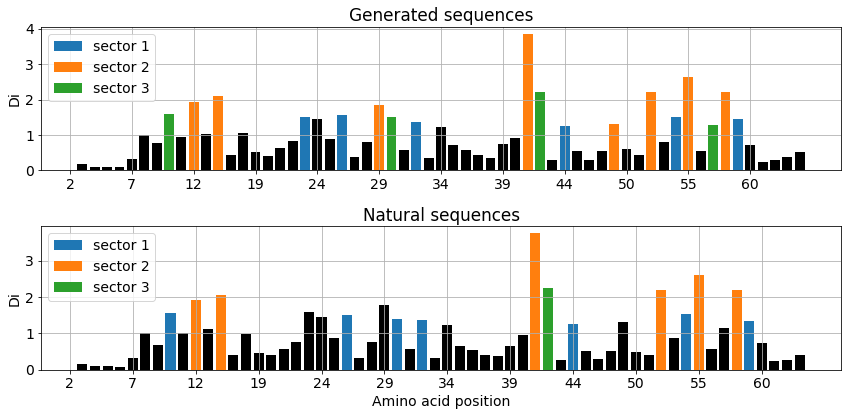

In [113]:
xvals = np.array([i+1 for i in range(len(Dsca['Di']))])
xvals_ref = np.array([i+1 for i in range(len(Dsca_ref['Di']))])
xticks = np.arange(0,len(Dseq_ref['ats']),5)
labels = [Dseq_ref['ats'][k] for k in xticks]

cmap = plt.cm.tab20
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 10)))
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].bar(xvals,Dsca['Di'], color='k')
axs[1].bar(xvals_ref,Dsca_ref['Di'], color='k')
axs[0].set_title('Generated sequences')
axs[1].set_title('Natural sequences')

for i in range(Dsect['kpos']):
    axs[0].bar(xvals[sg[i]], Dsca['Di'][sg[i]], label = 'sector '+str(i+1))
for i in range(Dsect_ref['kpos']):
    axs[1].bar(xvals[sr[i]], Dsca_ref['Di'][sr[i]], label = 'sector '+str(i+1))

for i in range(2):
    axs[i].set_ylabel('Di')
    axs[i].set_xticklabels(labels)
    axs[i].set_xticks(xticks)
    axs[i].grid()
    axs[i].legend()

plt.xlabel('Amino acid position')
plt.tight_layout()
plt.savefig('../figures/sca.pdf')

Histogram of pairwise Hamming distance of sequences in MSA and generated ones.

In [114]:
new_seq, _ = toolkit.convert_potts(gen_1e4['seq'], parameters['index'])

In [115]:
pairwise = (n - new_seq @ new_seq.T).reshape([-1,1])
pairwise_MSA = (n - v_traj_onehot @ v_traj_onehot.T).reshape([-1,1])

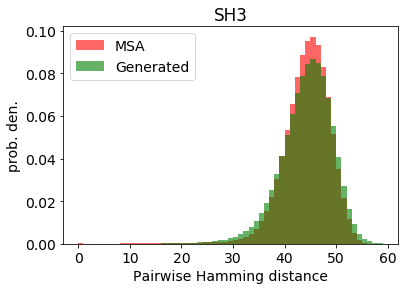

In [116]:
plt.hist(pairwise_MSA, int(max(pairwise_MSA)), density = True, alpha = 0.6, label='MSA',color='r')
plt.hist(pairwise, int(max(pairwise)), density = True, alpha = 0.6, label='Generated',color='g')
plt.xlabel('Pairwise Hamming distance')
plt.ylabel('prob. den.')
plt.title('SH3')
plt.legend()
plt.show()

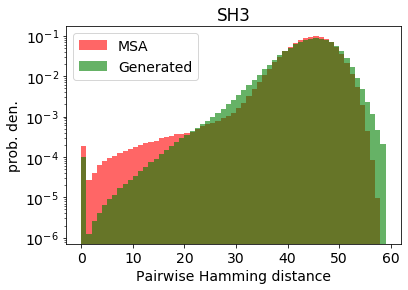

In [117]:
plt.yscale('log')
plt.hist(pairwise_MSA, int(max(pairwise_MSA)), density = True, alpha = 0.6, label='MSA',color='r')
plt.hist(pairwise, int(max(pairwise)), density = True, alpha = 0.6, label='Generated',color='g')
plt.xlabel('Pairwise Hamming distance')
plt.ylabel('prob. den.')
plt.title('SH3')
plt.legend()
plt.show()

In [118]:
ipca = IncrementalPCA(n_components=2, batch_size=3)
ipca.fit(v_traj_onehot)
msa_array = ipca.transform(v_traj_onehot) #PCA
new_array = ipca.transform(new_seq) 
print(ipca.explained_variance_ratio_)

[0.03581977 0.01836506]


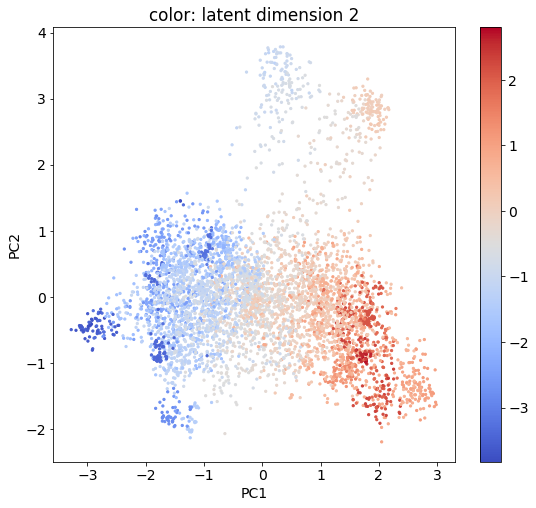

In [119]:
ldim = 1

plt.figure(figsize=[9,8]) # MSA
plt.scatter(msa_array[:,0], msa_array[:,1],s=5, c=z_test[:, ldim],cmap=plt.cm.coolwarm) 
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('color: latent dimension '+str(ldim+1))
plt.show()

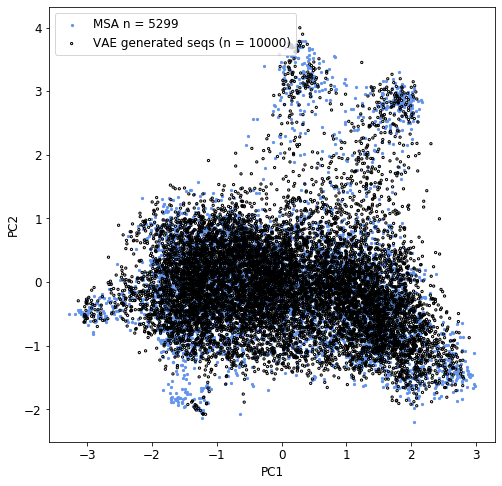

In [120]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=[8,8])
plt.scatter(msa_array[:,0], msa_array[:,1],label = 'MSA n = '+str(N),s=5, c = 'cornflowerblue')
#plt.scatter(msa_array[tst,0], msa_array[tst,1],label='Sho1 orthologs',s=5, c = 'r')
plt.scatter(new_array[:,0], new_array[:,1],label='VAE generated seqs (n = 10000)'
            ,s=5, alpha = 1, facecolors='none', edgecolors='k')
#plt.scatter(new_ortho[:,0], new_ortho[:,1],s=5, c = 'g')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig('../figures/pca.pdf')
plt.show()

In [121]:
v_traj_newall, _ = toolkit.convert_potts(gen_1e4['seq'], parameters['index'])
z_new_all = model.get_z(torch.FloatTensor(v_traj_newall)).cpu().detach().numpy() 

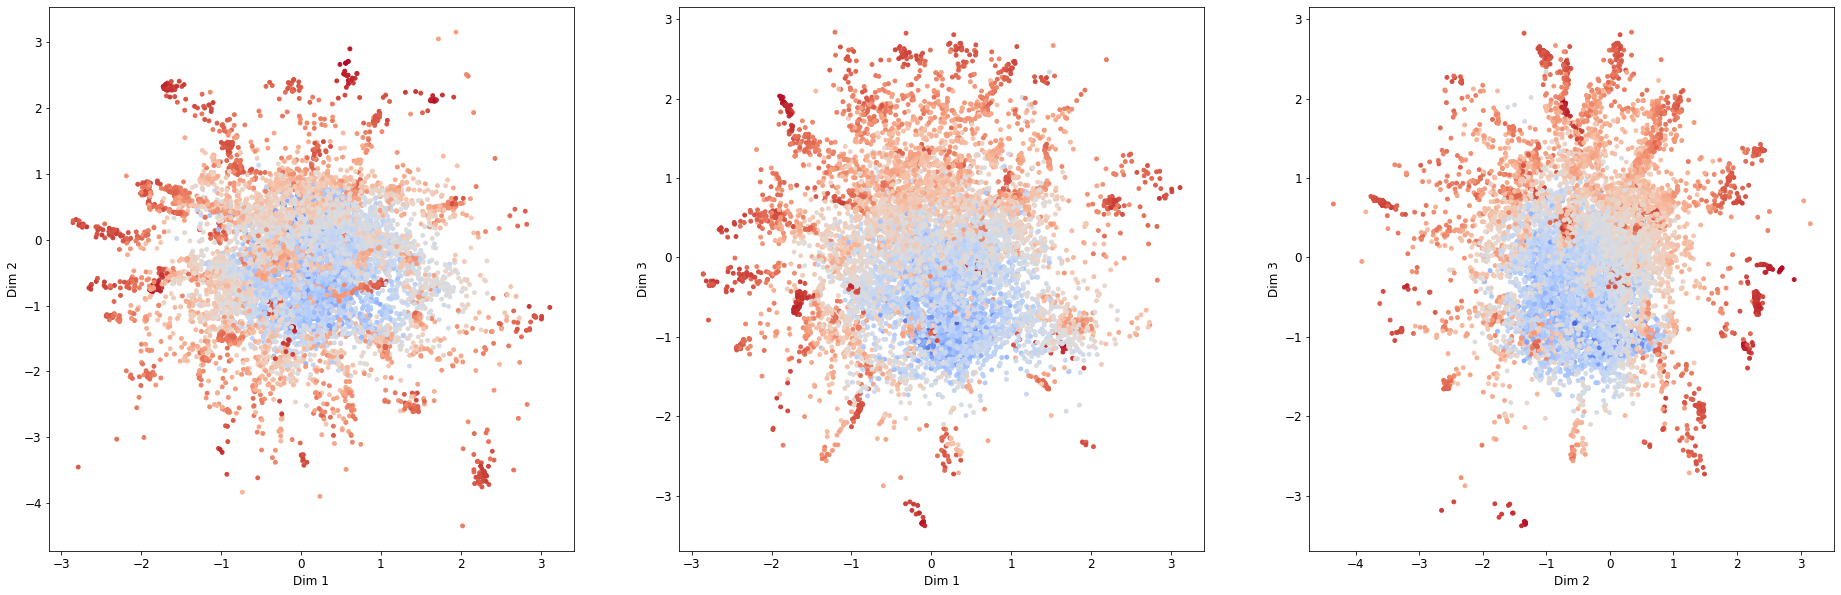

In [122]:
# Distribution of all generated sequenced encoded in latent space
fig, axs = plt.subplots(1,3,figsize=[32,10])
axs[0].scatter(z_new_all[:,0], z_new_all[:,1],s=15, c=gen_1e4['logP'],cmap=plt.cm.coolwarm)
axs[1].scatter(z_new_all[:,0], z_new_all[:,2],s=15, c=gen_1e4['logP'],cmap=plt.cm.coolwarm)
axs[2].scatter(z_new_all[:,1], z_new_all[:,2],s=15, c=gen_1e4['logP'],cmap=plt.cm.coolwarm)

axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')
axs[2].set_xlabel('Dim 2')
axs[2].set_ylabel('Dim 3')
plt.show()

In [98]:
np.log(30/59),15/59

(-0.6763400622435641, 0.2542372881355932)